In [1]:
from libdatasets import *
import librun
import libstop
from importlib import reload
from libadversarial import uncertainty_stop
from libstop import rank_stop_conds
from dotenv import load_dotenv; load_dotenv();
import libactive; reload(libactive)
import matplotlib.pyplot as plt
import math

In [2]:
matrix = {
    # Dataset fetchers should cache if possible
    # Lambda wrapper required for function to be pickleable (sent to other threads via joblib)
    "datasets": [
        #("anuran", wrap(anuran, None)),
        #("avila", wrap(avila, None)),
        #("covertype", wrap(covertype, None)),
        #("rcv1", wrap(rcv1, None)),
        #("sensorless", wrap(sensorless, None)),
        ("spamassassin", wrap(spamassassin, None)),
        #("splice", wrap(splice, None)),
        #("swarm", wrap(swarm, None)),
        #("smartphone", wrap(smartphone, None))
    ],
    "dataset_mutators": {
        "none": (lambda *x, **kwargs: x),
    },
    "methods": [
        ("uncertainty", partial(uncertainty_stop, n_instances=10)),
    ],
    "models": [
        "svm-linear"
    ],
    "meta": {
        "dataset_size": 1000,
        "labelled_size": 10,
        "test_size": 0.5,
        "n_runs": 10,
        "ret_classifiers": True,
        "ensure_y": True,
        "stop_info": True,
        "aggregate": False,
        "stop_function": ("len1000", lambda learner: learner.y_training.shape[0] >= 1000),
        "pool_subsample": 1000
    }
}

In [3]:
results = librun.run(matrix, force_cache=True, fragment_run_start=0, fragment_run_end=9)
results_plots = [result[0] for result in results]
classifiers = [result[1] for result in results]
classifiers = [clf for clf in classifiers]

['C:\\Users\\Zac\\AppData\\Local\\pypoetry\\Cache\\virtualenvs\\research-KKf5lz0r-py3.8\\lib\\site-packages\\ipykernel_launcher.py', '-f', 'C:\\Users\\Zac\\AppData\\Roaming\\jupyter\\runtime\\kernel-54c9299c-ff2c-455f-a504-a4a00a4f8e96.json']


Experiment:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
reload(libstop); from libstop import *
def acc_wrapper(**kwargs):
    x, diffs = first_acc(**kwargs)
    return [np.nan] +diffs
metrics = ['uncertainty_variance', 'uncertainty_variance_selected', 'uncertainty_average', 
           "n_support", "entropy_max", "expected_error_min", kappa_metric, acc_wrapper, SSNCut_values, fscore] # 
names = ['Uncertainty Variance', 'Queried Uncertainty Variance', 'Mean Uncertainty', '# support vectors', 'Max entropy', 'Min Expected Error', 'Kappa Agreement', 'First Accuracy', 'Clustering Agreement', 'Estimated F-score']

#metrics = [lambda *args, **kwargs: list(fscore(*args, **kwargs))] # 
#names = ['Estimated F-score']

In [11]:
results = results_plots[0][1]
conf = results_plots[0][0]
X, y = getattr(libdatasets, conf.dataset_name)(None)
unlabelled_pools = []
y_oracles = []
# WARN: This is not the same as the job numbers! Unfortunately they're not easily accessible
for i in range(len(results)):
    _, X_unlabelled, _, Y_oracle, _, _ = active_split(
        X, y, labeled_size=conf.meta['labelled_size'], test_size=conf.meta['test_size'], random_state=check_random_state(i), ensure_y=conf.meta['ensure_y']
    )
    unlabelled_pools.append(X_unlabelled)
    y_oracles.append(Y_oracle)

In [12]:
computed = {}
for metric, name in zip(metrics, names):
    if name in computed:
        continue
    if isinstance(metric, str):
        values = np.array([results[i][metric] for i in range(len(results))])
    else:
        values = np.array([metric(**results[i], classifiers=classifiers[0][i], X_unlabelled=unlabelled_pools[i], Y_oracle=y_oracles[i]) for i in range(len(results))])

    computed[name] = values


C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\sklearn\manifold\_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
C:\Users\Zac\AppData\Local\pypoetry\Cache\virtualenvs\research-KKf5lz0r-py3.8\lib\site-packages\sklearn\manifold

In [21]:
list(computed.keys())

['Uncertainty Variance',
 'Queried Uncertainty Variance',
 'Mean Uncertainty',
 '# support vectors',
 'Max entropy',
 'Min Expected Error',
 'Kappa Agreement',
 'First Accuracy',
 'Clustering Agreement',
 'Estimated F-score']

<ipython-input-74-70726f958953>:33: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.tight_layout()


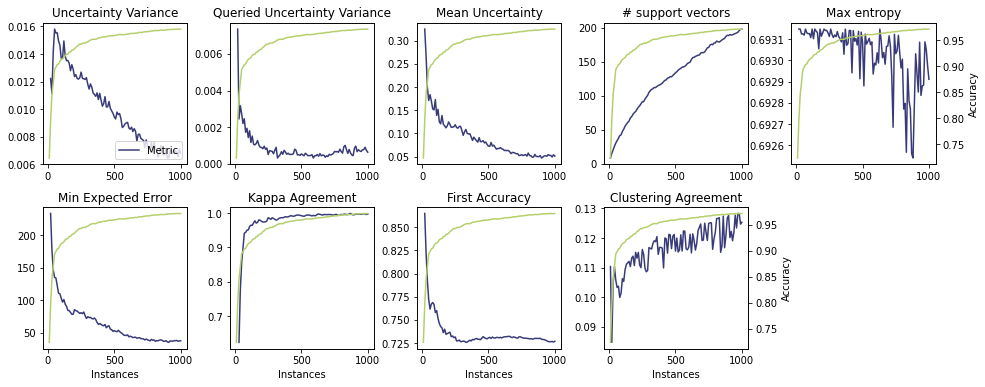

In [74]:
fig = plt.figure(figsize=(16,6))
plt.subplots_adjust(wspace=10, hspace=0.3)
from matplotlib.gridspec import GridSpec
gs = fig.add_gridspec(2,20)
cm = plt.cm.get_cmap('tab20b')
for j, (metric, name) in enumerate(zip(metrics, names)):
    if name == "Estimated F-score":
        continue
        
    if j > 4:
        x = j%5
        ax = fig.add_subplot(gs[j//5, x*4:(x+1)*4])
    else:
        x = j%5
        ax = fig.add_subplot(gs[j//5, x*4:(x+1)*4])
        
    values = computed[name]
        
    ax.plot(results[0].x, np.mean(values, axis=0), color=cm.colors[0], label="Metric" if j == 0 else None)
    ax2 = ax.twinx()
    ax2.plot(results[0].x, np.mean(np.array([results[i]['accuracy_score'] for i in range(len(results))]), axis=0), color=cm.colors[6], label="Accuracy" if j == 0 else None)
    if j == 0:
        ax.legend(loc='lower right')
    ax2.set_ylabel('Accuracy')
    ax.set_title(name)
    
    if j != 4 and j != 8:
        ax2.axes.get_yaxis().set_visible(False)
    
    if j > 4:
        ax.set_xlabel("Instances")

fig.tight_layout()

In [65]:
fig.savefig('figures/metrics_comparison.png')

In [10]:
np.isin(10, [0,1,2,10])

array(True)

In [23]:
mask = np.ones(5, dtype=bool)

In [31]:
np.array([1,2,3,4,5])[[[2]]]==np.array([1,2,3,4,5])[[2]]

<ipython-input-31-5d9c77e28f8f>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  np.array([1,2,3,4,5])[[[2]]]==np.array([1,2,3,4,5])[[2]]


array([ True])